In [1]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import os
import torch
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset,Dataset,random_split
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchinfo import summary
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [2]:
data = pd.read_csv('icml_face_data.csv')

In [3]:
data.rename(columns = {' Usage': 'Usage', ' pixels': 'Pixels'}, inplace=True)

In [4]:
data

,emotion,Usage,Pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


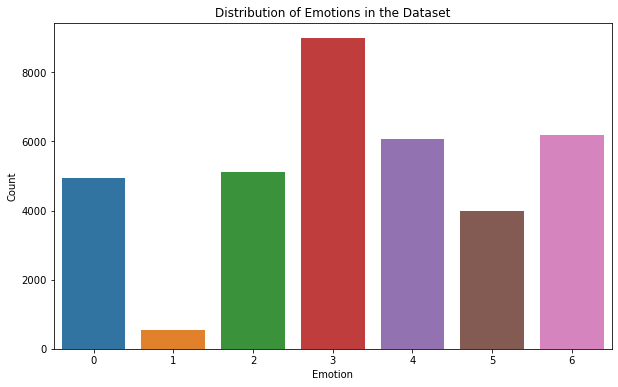

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data = data)
plt.title('Distribution of Emotions in the Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [6]:
data['Pixels'] = data['Pixels'].apply(lambda x: np.array(x.split(), dtype = np.uint8))

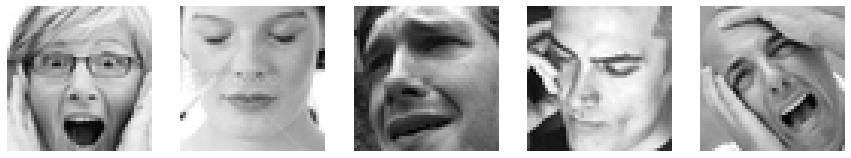

['Surprise', 'Neutral', 'Sad', 'Angry', 'Sad']


In [7]:
sample_indices = np.random.choice(len(data), 5, replace=False)
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
fig, axes = plt.subplots(1,5, figsize=(15, 5))
op = []
for i, index in enumerate(sample_indices):
    emotion = data['emotion'][index]
    pixels = data['Pixels'][index]
    image = pixels.reshape(48, 48) 

    axes[i].imshow(image, cmap='gray')
    op.append(emotions[emotion])
    axes[i].axis('off')

plt.show()
print(op)

In [8]:
data.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [9]:
data.head(7)

,emotion,Usage,Pixels
0,0,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."
5,2,Training,"[55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151, ..."
6,4,Training,"[20, 17, 19, 21, 25, 38, 42, 42, 46, 54, 56, 6..."


In [10]:
data['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [11]:
train_dataset = data[data['Usage'] == 'Training'].drop(columns=['Usage'])
val_dataset = data[data['Usage'] == 'PublicTest'].drop(columns=['Usage'])
test_dataset = data[data['Usage'] == 'PrivateTest'].drop(columns=['Usage'])

In [12]:
pixel_columns = train_dataset['Pixels']

all_pixels = [pixel for sublist in pixel_columns for pixel in sublist]

total_mean_tr = np.mean(all_pixels)
total_std_tr = np.std(all_pixels)
print("Total mean value of all pixels in training :", total_mean_tr)
print("Total std value of all pixels in training :", total_std_tr)

Total mean value of all pixels in training : 129.47433955331468
Total std value of all pixels in training : 65.02727348443116


In [13]:
pixel_columns = val_dataset['Pixels']

all_pixels = [pixel for sublist in pixel_columns for pixel in sublist]

total_mean_val = np.mean(all_pixels)
total_std_val = np.std(all_pixels)
print("Total mean value of all pixels in Validation:", total_mean_val)
print("Total std value of all pixels in training :", total_std_val)

Total mean value of all pixels in Validation: 128.98103217586143
Total std value of all pixels in training : 65.0060051006662


In [14]:
pixel_columns = test_dataset['Pixels']

all_pixels = [pixel for sublist in pixel_columns for pixel in sublist]

total_mean_test = np.mean(all_pixels)
total_std_test = np.std(all_pixels)
print("Total mean value of all pixels in test:", total_mean_test)
print("Total std value of all pixels in training :", total_std_test)

Total mean value of all pixels in test: 129.08289168678988
Total std value of all pixels in training : 65.35151723799241


In [15]:
train_dataset['Pixels'] = (train_dataset['Pixels'] - total_mean_tr) / total_std_tr

In [16]:
val_dataset['Pixels'] = (val_dataset['Pixels'] - total_mean_val) / total_std_val

In [17]:
test_dataset['Pixels'] = (test_dataset['Pixels'] - total_mean_test) / total_std_test

In [18]:
train_dataset

,emotion,Pixels
0,0,"[-0.9146060778260068, -0.760824449531316, -0.7..."
1,0,"[0.3310251113609891, 0.31564694853152003, 0.26..."
2,2,"[1.561278137718516, 1.2690930439586035, 0.4079..."
3,4,"[-1.6220015679815847, -1.498976265345832, -1.4..."
4,6,"[-1.9295648245709665, -1.9910774758888428, -1...."
...,...,...
28704,2,"[-0.6993117982134396, -0.6839336353839706, -0...."
28705,0,"[-0.23796691332936704, -0.2687232389883052, -0..."
28706,4,"[-0.8530934265081305, -0.7454462867018469, -0...."
28707,0,"[1.4228746722532943, 1.4997654864006398, 1.130..."


In [19]:
val_dataset

,emotion,Pixels
28709,0,"[1.9231910595111672, 1.9231910595111672, 1.923..."
28710,1,"[0.41563802886053175, 0.8463674661892847, 1.06..."
28711,4,"[-0.9226998656966651, -0.16892335037134734, -1..."
28712,6,"[1.1694145441858494, 1.1386481558052242, 1.646..."
28713,3,"[-0.6458023702710382, -0.768867923793539, -0.8..."
...,...,...
32293,4,"[0.7540683010474091, 0.7233019126667839, 0.661..."
32294,3,"[-1.5995604100704197, -1.4611116623576064, -1...."
32295,4,"[1.9385742537014798, 1.9385742537014798, 1.938..."
32296,4,"[-1.476494856547919, -1.5995604100704197, -1.5..."


In [20]:
test_dataset

,emotion,Pixels
32298,0,"[0.6261080085440276, -0.1695888964050981, -0.4..."
32299,5,"[-1.8680957512003473, -1.8986994783137752, -1...."
32300,6,"[1.5748235490602929, 1.6972384575140047, 1.712..."
32301,4,"[1.0851639152454464, 1.0392583245753044, 0.304..."
32302,2,"[-1.3631342538287867, -1.5467566165093543, -1...."
...,...,...
35882,6,"[-1.2101156182616473, -1.4243417080556426, -1...."
35883,3,"[0.7485229169977393, 0.6873154627708835, 0.656..."
35884,0,"[-1.7150771156332076, -1.7150771156332076, -1...."
35885,3,"[-1.5161528893959262, -1.5467566165093543, -1...."


In [21]:
Y_train = train_dataset['emotion'].values
Y_val = val_dataset['emotion'].values
Y_test = test_dataset['emotion'].values

In [22]:
X_train = train_dataset['Pixels'].values
X_val = val_dataset['Pixels'].values
X_test = test_dataset['Pixels'].values

In [23]:
X_train = np.stack(X_train).astype(np.float32)
X_train = torch.from_numpy(X_train)

In [24]:
X_val = np.stack(X_val).astype(np.float32)
X_val = torch.from_numpy(X_val)

In [25]:
X_test = np.stack(X_test).astype(np.float32)
X_test = torch.from_numpy(X_test)

In [26]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape,  X_val.shape, Y_val.shape

(torch.Size([28709, 2304]),
 (28709,),
 torch.Size([3589, 2304]),
 (3589,),
 torch.Size([3589, 2304]),
 (3589,))

In [27]:
X_train = X_train.view(28709, 48, 48, 1)
X_val = X_val.view(3589, 48, 48, 1)
X_test = X_test.view(3589, 48, 48, 1)

In [28]:
X_train = X_train.squeeze(-1)
X_train = X_train.unsqueeze(1).repeat(1, 3, 1, 1)

X_val = X_val.squeeze(-1)
X_val = X_val.unsqueeze(1).repeat(1, 3, 1, 1)

X_test = X_test.squeeze(-1)
X_test = X_test.unsqueeze(1).repeat(1, 3, 1, 1)

In [29]:
Y_train = torch.from_numpy(Y_train)
Y_val = torch.from_numpy(Y_val)
Y_test = torch.from_numpy(Y_test)
Y_train = Y_train.view(-1)
Y_test = Y_test.view(-1)
Y_val = Y_val.view(-1)

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [31]:
import torch
import torch.nn as nn

class BaseModel(nn.Module):
    def __init__(self, num_classes = 7):
        super(BaseModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 3 * 3, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

model = BaseModel(num_classes = 7).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
BaseModel                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       73,856
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       295,168
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       590,080
│    └─ReLU: 2-10                        --
│    └─MaxPool2d: 2-11                   --
│    └─Conv2d: 2-12                      1,180,160
│    └─ReLU: 2-13                        --
│    └─Conv2d: 2-14                      2,359,808
│    └─ReLU: 2-15                        --
│    └─MaxPool2d: 2-16                   --
├─Sequential: 1-2                        --
│    └─Linear: 2-17                      18,878,464
│    └─ReLU: 2-18               

In [32]:
import time
s = time.time()

torch.manual_seed(18)
np.random.seed(18)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 10

bs = 16
loss_val_array , loss_train , accuracy_train_array , accuracy_val_array = [], [], [], []

for epoch in range(epochs):
    model.train()
    loss_sum_train = 0
    c = 0
    acc = 0
    for j in range(0, len(X_train), bs):
        c += 1
        X_traini = X_train[j:j+bs].to(device)
        Y_traini = Y_train[j:j+bs].to(device)
        y_pred = model(X_traini)
        loss = criterion(y_pred, Y_traini)
        loss_sum_train += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(y_pred.data, 1)
        accuracy = (predicted == Y_traini).sum().item() / len(Y_traini)
        acc += accuracy

    accuracy_train_array.append(acc/c)

    loss_avg = loss_sum_train / c
    loss_train.append(loss_avg.item())

    print(f"Epoch No.{epoch + 1} -> Training loss: {loss_avg}")
    print(f"Epoch No.{epoch + 1} -> Training Accuracy: {acc/c}")

    model.eval()

    with torch.no_grad():
        loss_val_sum = 0
        C = 0
        acc = 0
        for k in range(0, len(X_val), bs):
            C += 1
            X_vali = X_val[k:k+bs].to(device)
            Y_vali = Y_val[k:k+bs].to(device)
            y_pred_val = model(X_vali)
            loss_val = criterion(y_pred_val, Y_vali)
            loss_val_sum += loss_val
            _, predicted_val = torch.max(y_pred_val.data, 1)
            accuracy_val = (predicted_val == Y_vali).sum().item() / len(Y_vali)
            acc += accuracy_val

        accuracy_val_array.append(acc / C)
        loss_val_avg = loss_val_sum / C
        loss_val_array.append(loss_val_avg.item())

    print(f"Epoch No.{epoch + 1} - Validation loss: {loss_val_avg}")
    print(f"Epoch No.{epoch + 1} - Validation Accuracy: {acc/C}")

e = time.time()

seconds = e - s

print(f"Execution time: {seconds:.4f} seconds")

Epoch No.1 -> Training loss: 1.6668992042541504
Epoch No.1 -> Training Accuracy: 0.3214902506963789
Epoch No.1 - Validation loss: 1.4084694385528564
Epoch No.1 - Validation Accuracy: 0.44711111111111107
Epoch No.2 -> Training loss: 1.3116836547851562
Epoch No.2 -> Training Accuracy: 0.4903690807799443
Epoch No.2 - Validation loss: 1.236215353012085
Epoch No.2 - Validation Accuracy: 0.5211666666666667
Epoch No.3 -> Training loss: 1.1328351497650146
Epoch No.3 -> Training Accuracy: 0.5668732590529248
Epoch No.3 - Validation loss: 1.1821753978729248
Epoch No.3 - Validation Accuracy: 0.5537222222222222
Epoch No.4 -> Training loss: 0.9611403346061707
Epoch No.4 -> Training Accuracy: 0.6361629526462395
Epoch No.4 - Validation loss: 1.2234876155853271
Epoch No.4 - Validation Accuracy: 0.5628333333333333
Epoch No.5 -> Training loss: 0.7743236422538757
Epoch No.5 -> Training Accuracy: 0.7138927576601671
Epoch No.5 - Validation loss: 1.3469465970993042
Epoch No.5 - Validation Accuracy: 0.5629444

In [33]:
with torch.no_grad():
    model.eval()
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_test = torch.tensor(Y_test, dtype=torch.long).to(device)
    loss_test_sum = 0
    acc_test = 0
    y_pred = []
    y_true = []

    for i in range(len(X_test)):
        X_test_i = X_test[i:i+1]
        Y_test_i = Y_test[i:i+1]

        y_pred_test = model(X_test_i)
        y_pred.append(torch.argmax(y_pred_test, dim=1).item())
        y_true.append(Y_test_i.item())

        loss_test = criterion(y_pred_test, Y_test_i)
        loss_test_sum += loss_test

        _, predicted_test = torch.max(y_pred_test.data, 1)
        accuracy_test = (predicted_test == Y_test_i).sum().item() / len(Y_test_i)
        acc_test += accuracy_test

    accuracy_test_result = acc_test / len(X_test)
    print(f"Accuracy: {accuracy_test_result * 100:.2f}%")

    loss = loss_test_sum/(len(X_test))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


<ipython-input-33-a811de81534e>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
<ipython-input-33-a811de81534e>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test, dtype=torch.long).to(device)


Accuracy: 56.56%


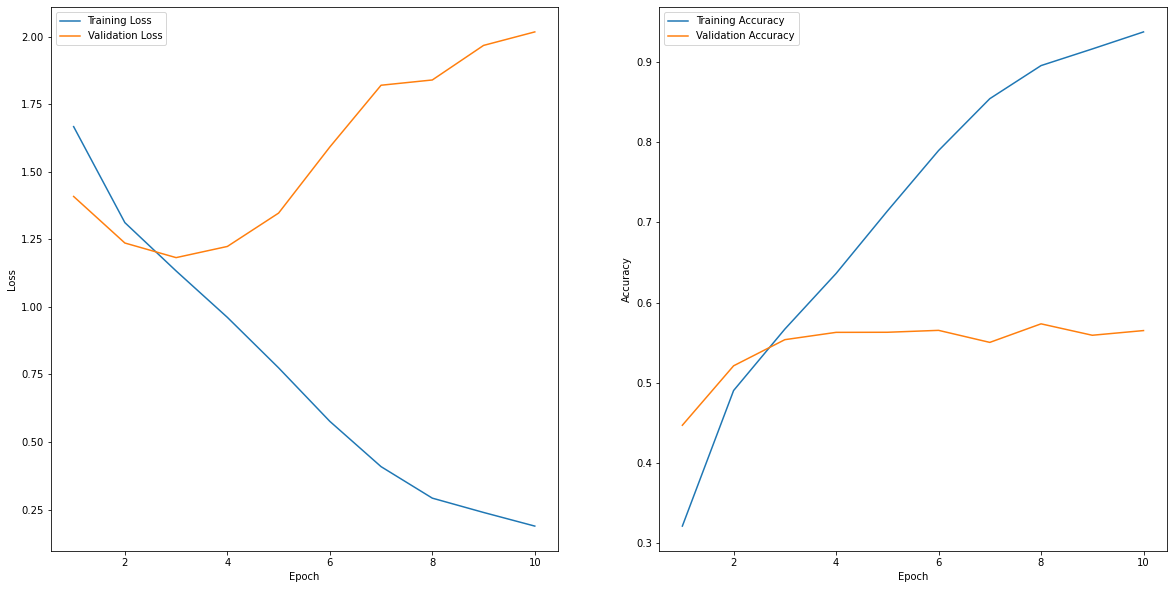

In [34]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot([i for i in range(1,epochs+1)], loss_train, label="Training Loss")
plt.plot([i for i in range(1,epochs+1)], loss_val_array, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot([i for i in range(1,epochs+1)], accuracy_train_array, label = "Training Accuracy")
plt.plot([i for i in range(1,epochs+1)], accuracy_val_array, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

In [35]:
con_mat = confusion_matrix(y_true, y_pred)

number_of_classes = con_mat.shape[0]

for i in range(number_of_classes):

    tp = con_mat[i, i]
    fn = np.sum(con_mat[i, :]) - tp
    fp = np.sum(con_mat[:, i]) - tp
    tn = np.sum(con_mat) - (tp + fn + fp)

    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0

    tpr = tp / (tp + fn) if tp + fn != 0 else 0
    fpr = fp / (fp + tn) if fp + tn != 0 else 0

    print(f"Class {i + 1} - True Positive Rate: {tpr:.2f}, False Positive Rate: {fpr:.2f}")
    print(f"Class {i + 1} - Precision: {precision:.2f}, Recall: {recall:.2f}")
    print()

Class 1 - True Positive Rate: 0.61, False Positive Rate: 0.15
Class 1 - Precision: 0.39, Recall: 0.61

Class 2 - True Positive Rate: 0.51, False Positive Rate: 0.01
Class 2 - Precision: 0.55, Recall: 0.51

Class 3 - True Positive Rate: 0.38, False Positive Rate: 0.07
Class 3 - Precision: 0.47, Recall: 0.38

Class 4 - True Positive Rate: 0.78, False Positive Rate: 0.07
Class 4 - Precision: 0.79, Recall: 0.78

Class 5 - True Positive Rate: 0.44, False Positive Rate: 0.11
Class 5 - Precision: 0.43, Recall: 0.44

Class 6 - True Positive Rate: 0.66, False Positive Rate: 0.03
Class 6 - Precision: 0.77, Recall: 0.66

Class 7 - True Positive Rate: 0.44, False Positive Rate: 0.08
Class 7 - Precision: 0.54, Recall: 0.44



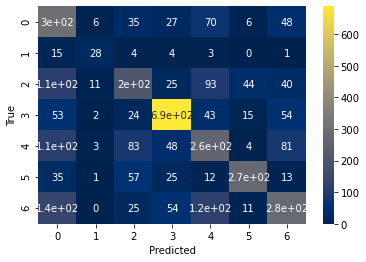

<Figure size 1440x720 with 0 Axes>

In [36]:
sns.heatmap(con_mat, annot = True, cmap = 'cividis', cbar = True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.figure(figsize=(20,10))
plt.show()

In [37]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Precision: 0.5800385034035689
Recall: 0.5656171635553079
F1: 0.5675131020863855


In [38]:
weights_val = model.state_dict()
torch.save(weights_val, "model.pth")

In [39]:
torch.cuda.memory_allocated()

760925696

In [40]:
import gc
torch.cuda.empty_cache()
gc.collect()

16542

In [41]:
torch.cuda.memory_allocated()

760925696

In [42]:
import time
s = time.time()

torch.manual_seed(18)
np.random.seed(18)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.001)

epochs = 10

bs = 16
loss_val_array , loss_train , accuracy_train_array , accuracy_val_array = [], [], [], []

for epoch in range(epochs):
    model.train()
    loss_sum_train = 0
    c = 0
    acc = 0
    for j in range(0, len(X_train), bs):
        c += 1
        X_traini = X_train[j:j+bs].to(device)
        Y_traini = Y_train[j:j+bs].to(device)
        y_pred = model(X_traini)
        loss = criterion(y_pred, Y_traini)
        loss_sum_train += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(y_pred.data, 1)
        accuracy = (predicted == Y_traini).sum().item() / len(Y_traini)
        acc += accuracy

    accuracy_train_array.append(acc/c)

    loss_avg = loss_sum_train / c
    loss_train.append(loss_avg.item())

    print(f"Epoch No.{epoch + 1} -> Training loss: {loss_avg}")
    print(f"Epoch No.{epoch + 1} -> Training Accuracy: {acc/c}")

    model.eval()

    with torch.no_grad():
        loss_val_sum = 0
        C = 0
        acc = 0
        for k in range(0, len(X_val), bs):
            C += 1
            X_vali = X_val[k:k+bs].to(device)
            Y_vali = Y_val[k:k+bs].to(device)
            y_pred_val = model(X_vali)
            loss_val = criterion(y_pred_val, Y_vali)
            loss_val_sum += loss_val
            _, predicted_val = torch.max(y_pred_val.data, 1)
            accuracy_val = (predicted_val == Y_vali).sum().item() / len(Y_vali)
            acc += accuracy_val

        accuracy_val_array.append(acc / C)
        loss_val_avg = loss_val_sum / C
        loss_val_array.append(loss_val_avg.item())

    print(f"Epoch No.{epoch + 1} - Validation loss: {loss_val_avg}")
    print(f"Epoch No.{epoch + 1} - Validation Accuracy: {acc/C}")

e = time.time()

seconds = e - s

print(f"Execution time: {seconds:.4f} seconds")

Epoch No.1 -> Training loss: 1.3222023248672485
Epoch No.1 -> Training Accuracy: 0.5001880222841225
Epoch No.1 - Validation loss: 1.2822377681732178
Epoch No.1 - Validation Accuracy: 0.5082222222222222
Epoch No.2 -> Training loss: 1.2818634510040283
Epoch No.2 -> Training Accuracy: 0.5145194986072423
Epoch No.2 - Validation loss: 1.2668856382369995
Epoch No.2 - Validation Accuracy: 0.5098333333333334
Epoch No.3 -> Training loss: 1.231161117553711
Epoch No.3 -> Training Accuracy: 0.5345194986072423
Epoch No.3 - Validation loss: 1.2909756898880005
Epoch No.3 - Validation Accuracy: 0.5142777777777778
Epoch No.4 -> Training loss: 1.1849639415740967
Epoch No.4 -> Training Accuracy: 0.5539206128133705
Epoch No.4 - Validation loss: 1.218193769454956
Epoch No.4 - Validation Accuracy: 0.5376666666666666
Epoch No.5 -> Training loss: 1.15395188331604
Epoch No.5 -> Training Accuracy: 0.567075208913649
Epoch No.5 - Validation loss: 1.2375959157943726
Epoch No.5 - Validation Accuracy: 0.5465
Epoch N

In [43]:
with torch.no_grad():
    model.eval()
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_test = torch.tensor(Y_test, dtype=torch.long).to(device)
    loss_test_sum = 0
    acc_test = 0
    y_pred = []
    y_true = []

    for i in range(len(X_test)):
        X_test_i = X_test[i:i+1]
        Y_test_i = Y_test[i:i+1]

        y_pred_test = model(X_test_i)
        y_pred.append(torch.argmax(y_pred_test, dim=1).item())
        y_true.append(Y_test_i.item())

        loss_test = criterion(y_pred_test, Y_test_i)
        loss_test_sum += loss_test

        _, predicted_test = torch.max(y_pred_test.data, 1)
        accuracy_test = (predicted_test == Y_test_i).sum().item() / len(Y_test_i)
        acc_test += accuracy_test

    accuracy_test_result = acc_test / len(X_test)
    print(f"Accuracy: {accuracy_test_result * 100:.2f}%")

    loss = loss_test_sum/(len(X_test))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


<ipython-input-43-a811de81534e>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
<ipython-input-43-a811de81534e>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test, dtype=torch.long).to(device)


Accuracy: 56.51%


In [44]:
weights_val_op = model.state_dict()
torch.save(weights_val_op, "model_op.pth")

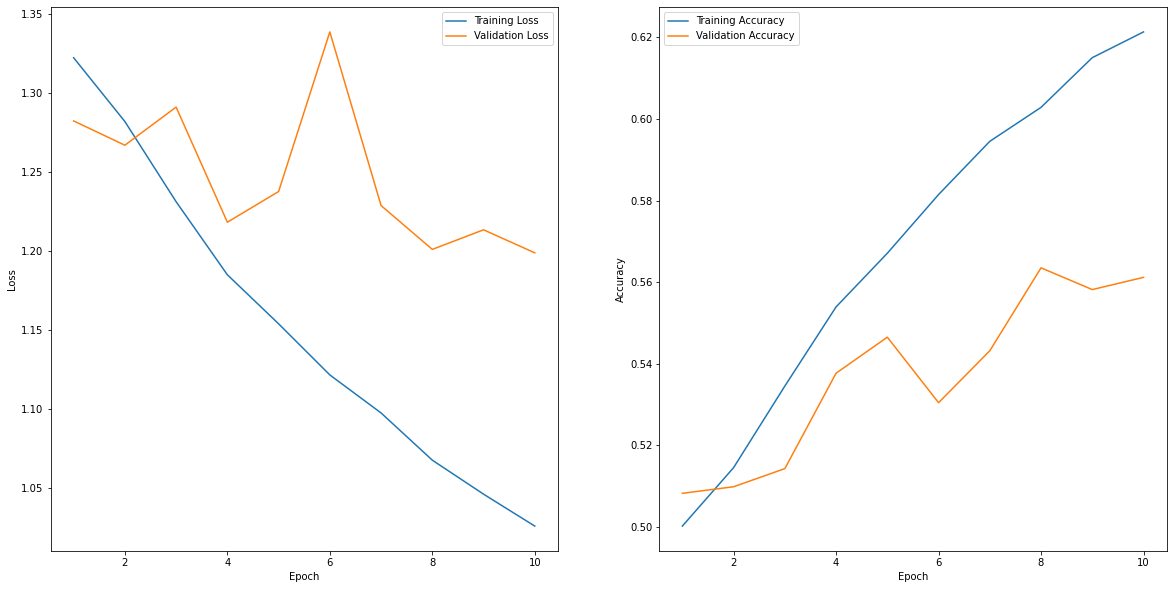

In [45]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot([i for i in range(1,epochs+1)], loss_train, label="Training Loss")
plt.plot([i for i in range(1,epochs+1)], loss_val_array, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot([i for i in range(1,epochs+1)], accuracy_train_array, label = "Training Accuracy")
plt.plot([i for i in range(1,epochs+1)], accuracy_val_array, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

In [46]:
con_mat = confusion_matrix(y_true, y_pred)

number_of_classes = con_mat.shape[0]

for i in range(number_of_classes):

    tp = con_mat[i, i]
    fn = np.sum(con_mat[i, :]) - tp
    fp = np.sum(con_mat[:, i]) - tp
    tn = np.sum(con_mat) - (tp + fn + fp)

    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0

    tpr = tp / (tp + fn) if tp + fn != 0 else 0
    fpr = fp / (fp + tn) if fp + tn != 0 else 0

    print(f"Class {i + 1} - True Positive Rate: {tpr:.2f}, False Positive Rate: {fpr:.2f}")
    print(f"Class {i + 1} - Precision: {precision:.2f}, Recall: {recall:.2f}")
    print()

Class 1 - True Positive Rate: 0.55, False Positive Rate: 0.11
Class 1 - Precision: 0.44, Recall: 0.55

Class 2 - True Positive Rate: 0.00, False Positive Rate: 0.00
Class 2 - Precision: 0.00, Recall: 0.00

Class 3 - True Positive Rate: 0.26, False Positive Rate: 0.07
Class 3 - Precision: 0.39, Recall: 0.26

Class 4 - True Positive Rate: 0.86, False Positive Rate: 0.10
Class 4 - Precision: 0.74, Recall: 0.86

Class 5 - True Positive Rate: 0.49, False Positive Rate: 0.14
Class 5 - Precision: 0.40, Recall: 0.49

Class 6 - True Positive Rate: 0.63, False Positive Rate: 0.03
Class 6 - Precision: 0.75, Recall: 0.63

Class 7 - True Positive Rate: 0.51, False Positive Rate: 0.08
Class 7 - Precision: 0.58, Recall: 0.51



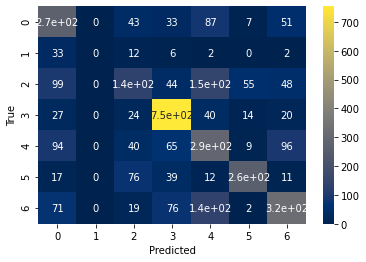

<Figure size 1440x720 with 0 Axes>

In [47]:
sns.heatmap(con_mat, annot = True, cmap = 'cividis', cbar = True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.figure(figsize=(20,10))
plt.show()

In [48]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Precision: 0.5544317087455066
Recall: 0.5650599052660908
F1: 0.5542045585389876


C:\Users\nages\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
import torch
import torch.nn as nn

class VGG13(nn.Module):
    def __init__(self, num_classes=7, input_size=(64,64)):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model_vgg1 = VGG13().to(device)
summary(model_vgg1)

Layer (type:depth-idx)                   Param #
VGG13                                    --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─MaxPool2d: 2-15                   --
│    └─Conv2d: 2-16                      1,180,160
│    └─ReLU: 2-17                        --
│    └─Conv2d: 2-18                      2,359,808
│    └─ReLU: 2-19              

In [50]:
import time

s = time.time()

torch.manual_seed(18)
np.random.seed(18)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg1.parameters(), lr=0.0001)

epochs = 10

bs = 16
loss_val_array, loss_train, accuracy_train_array, accuracy_val_array = [], [], [], []

for epoch in range(epochs):
    model_vgg1.train()
    loss_sum_train = 0
    c = 0
    acc = 0
    for j in range(0, len(X_train), bs):
        c += 1
        X_traini = X_train[j:j+bs].to(device)
        Y_traini = Y_train[j:j+bs].to(device)
        y_pred = model_vgg1(X_traini)
        loss = criterion(y_pred, Y_traini)
        loss_sum_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(y_pred.data, 1)
        accuracy = (predicted == Y_traini).sum().item() / len(Y_traini)
        acc += accuracy

    accuracy_train_array.append(acc/c)

    loss_avg = loss_sum_train / c
    loss_train.append(loss_avg)

    print(f"Epoch No.{epoch + 1} -> Training loss: {loss_avg}")
    print(f"Epoch No.{epoch + 1} -> Training Accuracy: {acc/c}")

    model_vgg1.eval()

    with torch.no_grad():
        loss_val_sum = 0
        C = 0
        acc = 0
        for k in range(0, len(X_val), bs):
            C += 1
            X_vali = X_val[k:k+bs].to(device)
            Y_vali = Y_val[k:k+bs].to(device)
            y_pred_val = model_vgg1(X_vali)
            loss_val = criterion(y_pred_val, Y_vali)
            loss_val_sum += loss_val.item()
            _, predicted_val = torch.max(y_pred_val.data, 1)
            accuracy_val = (predicted_val == Y_vali).sum().item() / len(Y_vali)
            acc += accuracy_val

        accuracy_val_array.append(acc / C)
        loss_val_avg = loss_val_sum / C
        loss_val_array.append(loss_val_avg)

    print(f"Epoch No.{epoch + 1} - Validation loss: {loss_val_avg}")
    print(f"Epoch No.{epoch + 1} - Validation Accuracy: {acc/C}")


e = time.time()

seconds = e - s

print(f"Execution time: {seconds:.4f} seconds")


Epoch No.1 -> Training loss: 1.8142158443881276
Epoch No.1 -> Training Accuracy: 0.25
Epoch No.1 - Validation loss: 1.8178261624442207
Epoch No.1 - Validation Accuracy: 0.24922222222222223
Epoch No.2 -> Training loss: 1.7998744888890088
Epoch No.2 -> Training Accuracy: 0.2524025069637883
Epoch No.2 - Validation loss: 1.7683002954059177
Epoch No.2 - Validation Accuracy: 0.2783888888888889
Epoch No.3 -> Training loss: 1.6060333507638789
Epoch No.3 -> Training Accuracy: 0.34578690807799445
Epoch No.3 - Validation loss: 1.4205843742688498
Epoch No.3 - Validation Accuracy: 0.4256111111111111
Epoch No.4 -> Training loss: 1.3381145980364766
Epoch No.4 -> Training Accuracy: 0.46066155988857943
Epoch No.4 - Validation loss: 1.2802401396963332
Epoch No.4 - Validation Accuracy: 0.49127777777777776
Epoch No.5 -> Training loss: 1.1814463708892173
Epoch No.5 -> Training Accuracy: 0.5390807799442897
Epoch No.5 - Validation loss: 1.2154240430725944
Epoch No.5 - Validation Accuracy: 0.5263333333333333


In [51]:
with torch.no_grad():
    model_vgg1.eval()
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_test = torch.tensor(Y_test, dtype=torch.long).to(device)
    loss_test_sum = 0
    acc_test = 0
    y_pred = []
    y_true = []

    for i in range(len(X_test)):
        X_test_i = X_test[i:i+1]
        Y_test_i = Y_test[i:i+1]

        y_pred_test = model_vgg1(X_test_i)
        y_pred.append(torch.argmax(y_pred_test, dim=1).item())
        y_true.append(Y_test_i.item())

        loss_test = criterion(y_pred_test, Y_test_i)
        loss_test_sum += loss_test

        _, predicted_test = torch.max(y_pred_test.data, 1)
        accuracy_test = (predicted_test == Y_test_i).sum().item() / len(Y_test_i)
        acc_test += accuracy_test

    accuracy_test_result = acc_test / len(X_test)
    print(f"Accuracy: {accuracy_test_result * 100:.2f}%")

    loss = loss_test_sum/(len(X_test))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


<ipython-input-51-edb5a79f102a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
<ipython-input-51-edb5a79f102a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test, dtype=torch.long).to(device)


Accuracy: 56.98%


In [54]:
weights_val_vgg1 = model_vgg1.state_dict()
torch.save(weights_val_vgg1, "model_vgg.pth")

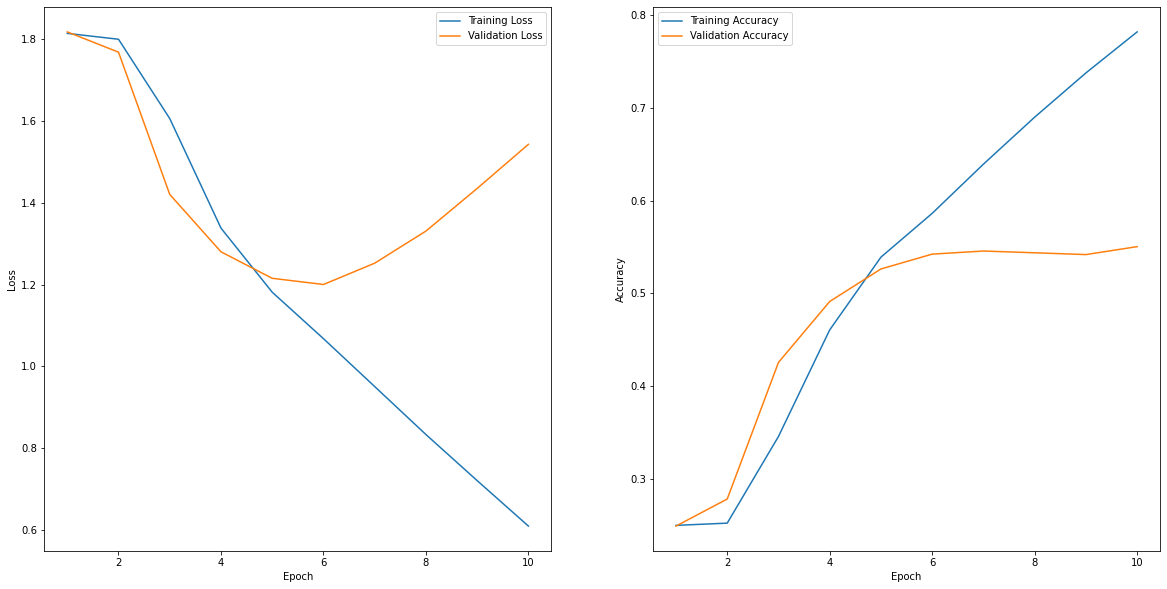

In [55]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot([i for i in range(1,epochs+1)], loss_train, label="Training Loss")
plt.plot([i for i in range(1,epochs+1)], loss_val_array, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot([i for i in range(1,epochs+1)], accuracy_train_array, label = "Training Accuracy")
plt.plot([i for i in range(1,epochs+1)], accuracy_val_array, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

In [56]:
con_mat = confusion_matrix(y_true, y_pred)

number_of_classes = con_mat.shape[0]

for i in range(number_of_classes):

    tp = con_mat[i, i]
    fn = np.sum(con_mat[i, :]) - tp
    fp = np.sum(con_mat[:, i]) - tp
    tn = np.sum(con_mat) - (tp + fn + fp)

    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0

    tpr = tp / (tp + fn) if tp + fn != 0 else 0
    fpr = fp / (fp + tn) if fp + tn != 0 else 0

    print(f"Class {i + 1} - True Positive Rate: {tpr:.2f}, False Positive Rate: {fpr:.2f}")
    print(f"Class {i + 1} - Precision: {precision:.2f}, Recall: {recall:.2f}")
    print()

Class 1 - True Positive Rate: 0.55, False Positive Rate: 0.10
Class 1 - Precision: 0.46, Recall: 0.55

Class 2 - True Positive Rate: 0.13, False Positive Rate: 0.00
Class 2 - Precision: 0.39, Recall: 0.13

Class 3 - True Positive Rate: 0.38, False Positive Rate: 0.10
Class 3 - Precision: 0.39, Recall: 0.38

Class 4 - True Positive Rate: 0.82, False Positive Rate: 0.07
Class 4 - Precision: 0.79, Recall: 0.82

Class 5 - True Positive Rate: 0.30, False Positive Rate: 0.09
Class 5 - Precision: 0.41, Recall: 0.30

Class 6 - True Positive Rate: 0.69, False Positive Rate: 0.03
Class 6 - Precision: 0.73, Recall: 0.69

Class 7 - True Positive Rate: 0.61, False Positive Rate: 0.12
Class 7 - Precision: 0.52, Recall: 0.61



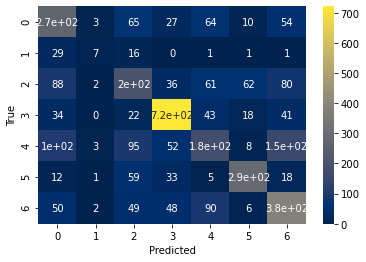

<Figure size 1440x720 with 0 Axes>

In [57]:
sns.heatmap(con_mat, annot = True, cmap = 'cividis', cbar = True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.figure(figsize=(20,10))
plt.show()

In [58]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Precision: 0.5629141245626339
Recall: 0.5697966007244358
F1: 0.562880432493043


In [59]:
import time

s = time.time()

torch.manual_seed(18)
np.random.seed(18)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg1.parameters(), lr=0.001, weight_decay = 0.001)

epochs = 10

bs = 16
loss_val_array, loss_train, accuracy_train_array, accuracy_val_array = [], [], [], []

for epoch in range(epochs):
    model_vgg1.train()
    loss_sum_train = 0
    c = 0
    acc = 0
    for j in range(0, len(X_train), bs):
        c += 1
        X_traini = X_train[j:j+bs].to(device)
        Y_traini = Y_train[j:j+bs].to(device)
        y_pred = model_vgg1(X_traini)
        loss = criterion(y_pred, Y_traini)
        loss_sum_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(y_pred.data, 1)
        accuracy = (predicted == Y_traini).sum().item() / len(Y_traini)
        acc += accuracy

    accuracy_train_array.append(acc/c)

    loss_avg = loss_sum_train / c
    loss_train.append(loss_avg)

    print(f"Epoch No.{epoch + 1} -> Training loss: {loss_avg}")
    print(f"Epoch No.{epoch + 1} -> Training Accuracy: {acc/c}")

    model_vgg1.eval()

    with torch.no_grad():
        loss_val_sum = 0
        C = 0
        acc = 0
        for k in range(0, len(X_val), bs):
            C += 1
            X_vali = X_val[k:k+bs].to(device)
            Y_vali = Y_val[k:k+bs].to(device)
            y_pred_val = model_vgg1(X_vali)
            loss_val = criterion(y_pred_val, Y_vali)
            loss_val_sum += loss_val.item()
            _, predicted_val = torch.max(y_pred_val.data, 1)
            accuracy_val = (predicted_val == Y_vali).sum().item() / len(Y_vali)
            acc += accuracy_val

        accuracy_val_array.append(acc / C)
        loss_val_avg = loss_val_sum / C
        loss_val_array.append(loss_val_avg)

    print(f"Epoch No.{epoch + 1} - Validation loss: {loss_val_avg}")
    print(f"Epoch No.{epoch + 1} - Validation Accuracy: {acc/C}")


e = time.time()

seconds = e - s

print(f"Execution time: {seconds:.4f} seconds")


Epoch No.1 -> Training loss: 1.4277291868390478
Epoch No.1 -> Training Accuracy: 0.4433217270194986
Epoch No.1 - Validation loss: 1.351151090198093
Epoch No.1 - Validation Accuracy: 0.4692777777777778
Epoch No.2 -> Training loss: 1.290169766586803
Epoch No.2 -> Training Accuracy: 0.5036629526462396
Epoch No.2 - Validation loss: 1.3038096075587802
Epoch No.2 - Validation Accuracy: 0.49594444444444447
Epoch No.3 -> Training loss: 1.2304025323942178
Epoch No.3 -> Training Accuracy: 0.5267896935933147
Epoch No.3 - Validation loss: 1.270498071246677
Epoch No.3 - Validation Accuracy: 0.5169444444444444
Epoch No.4 -> Training loss: 1.1883878310078697
Epoch No.4 -> Training Accuracy: 0.5450696378830083
Epoch No.4 - Validation loss: 1.214972398016188
Epoch No.4 - Validation Accuracy: 0.5424444444444444
Epoch No.5 -> Training loss: 1.149351498941193
Epoch No.5 -> Training Accuracy: 0.560633704735376
Epoch No.5 - Validation loss: 1.215498157342275
Epoch No.5 - Validation Accuracy: 0.5374444444444

In [60]:
with torch.no_grad():
    model_vgg1.eval()
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_test = torch.tensor(Y_test, dtype=torch.long).to(device)
    loss_test_sum = 0
    acc_test = 0
    y_pred = []
    y_true = []

    for i in range(len(X_test)):
        X_test_i = X_test[i:i+1]
        Y_test_i = Y_test[i:i+1]

        y_pred_test = model_vgg1(X_test_i)
        y_pred.append(torch.argmax(y_pred_test, dim=1).item())
        y_true.append(Y_test_i.item())

        loss_test = criterion(y_pred_test, Y_test_i)
        loss_test_sum += loss_test

        _, predicted_test = torch.max(y_pred_test.data, 1)
        accuracy_test = (predicted_test == Y_test_i).sum().item() / len(Y_test_i)
        acc_test += accuracy_test

    accuracy_test_result = acc_test / len(X_test)
    print(f"Accuracy: {accuracy_test_result * 100:.2f}%")

    loss = loss_test_sum/(len(X_test))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


<ipython-input-60-edb5a79f102a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
<ipython-input-60-edb5a79f102a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test, dtype=torch.long).to(device)


Accuracy: 54.03%


In [61]:
weights_val_vgg_op = model_vgg1.state_dict()
torch.save(weights_val_vgg_op, "model_vgg_op.pth")

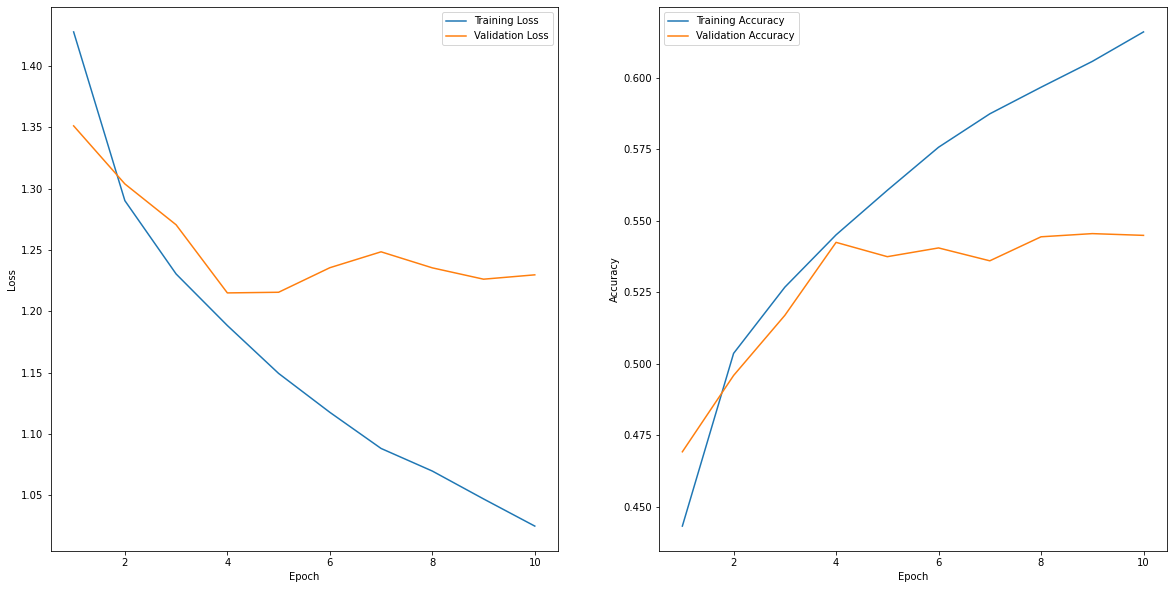

In [62]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot([i for i in range(1,epochs+1)], loss_train, label="Training Loss")
plt.plot([i for i in range(1,epochs+1)], loss_val_array, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot([i for i in range(1,epochs+1)], accuracy_train_array, label = "Training Accuracy")
plt.plot([i for i in range(1,epochs+1)], accuracy_val_array, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

In [63]:
con_mat = confusion_matrix(y_true, y_pred)

number_of_classes = con_mat.shape[0]

for i in range(number_of_classes):

    tp = con_mat[i, i]
    fn = np.sum(con_mat[i, :]) - tp
    fp = np.sum(con_mat[:, i]) - tp
    tn = np.sum(con_mat) - (tp + fn + fp)

    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0

    tpr = tp / (tp + fn) if tp + fn != 0 else 0
    fpr = fp / (fp + tn) if fp + tn != 0 else 0

    print(f"Class {i + 1} - True Positive Rate: {tpr:.2f}, False Positive Rate: {fpr:.2f}")
    print(f"Class {i + 1} - Precision: {precision:.2f}, Recall: {recall:.2f}")
    print()

Class 1 - True Positive Rate: 0.57, False Positive Rate: 0.14
Class 1 - Precision: 0.39, Recall: 0.57

Class 2 - True Positive Rate: 0.00, False Positive Rate: 0.00
Class 2 - Precision: 0.00, Recall: 0.00

Class 3 - True Positive Rate: 0.19, False Positive Rate: 0.05
Class 3 - Precision: 0.41, Recall: 0.19

Class 4 - True Positive Rate: 0.82, False Positive Rate: 0.08
Class 4 - Precision: 0.77, Recall: 0.82

Class 5 - True Positive Rate: 0.57, False Positive Rate: 0.20
Class 5 - Precision: 0.36, Recall: 0.57

Class 6 - True Positive Rate: 0.55, False Positive Rate: 0.02
Class 6 - Precision: 0.78, Recall: 0.55

Class 7 - True Positive Rate: 0.43, False Positive Rate: 0.07
Class 7 - Precision: 0.58, Recall: 0.43



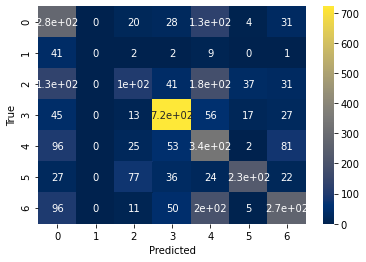

<Figure size 1440x720 with 0 Axes>

In [64]:
sns.heatmap(con_mat, annot = True, cmap = 'cividis', cbar = True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.figure(figsize=(20,10))
plt.show()

In [65]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Precision: 0.5547116680775224
Recall: 0.540261911395932
F1: 0.5312878880846599


C:\Users\nages\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNetB(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNetB, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
modelResnet0 = ResNetB().to(device)
summary(modelResnet0)

Layer (type:depth-idx)                   Param #
ResNetB                                  --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

In [67]:
import time

s = time.time()

torch.manual_seed(18)
np.random.seed(18)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelResnet0.parameters(), lr = 0.0001)

epochs = 10

bs = 16
loss_val_array , loss_train , accuracy_train_array , accuracy_val_array = [], [], [], []

for epoch in range(epochs):
    modelResnet0.train() 
    loss_sum_train = 0
    c = 0
    acc = 0
    for j in range(0, len(X_train), bs):
        
        c += 1
        X_traini = X_train[j:j+bs]
        X_traini = X_traini.to(device)
        Y_traini = Y_train[j:j+bs]
        Y_traini = Y_traini.to(device)
        y_pred = modelResnet0(X_traini) 
        loss = criterion(y_pred, Y_traini)
        loss_sum_train += loss.item()  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(y_pred, 1) 
        accuracy = (predicted == Y_traini).sum().item() / len(Y_traini)
        acc += accuracy

    accuracy_train_array.append(acc/c)

    loss_avg = loss_sum_train / c
    loss_train.append(loss_avg)

    print(f"Epoch No.{epoch + 1} -> Training loss: {loss_avg}")
    print(f"Epoch No.{epoch + 1} -> Training Accuracy: {acc/c}")

    modelResnet0.eval()  

    with torch.no_grad():
        loss_val_sum = 0
        C = 0
        acc = 0
        for k in range(0, len(X_val), bs):
            C += 1
            X_vali = X_val[k:k+bs]
            Y_vali = Y_val[k:k+bs]
            X_vali = X_vali.to(device)
            Y_vali = Y_vali.to(device)
            y_pred_val = modelResnet0(X_vali)  
            loss_val = criterion(y_pred_val, Y_vali)
            loss_val_sum += loss_val.item()  
            _, predicted_val = torch.max(y_pred_val, 1)  
            accuracy_val = (predicted_val == Y_vali).sum().item() / len(Y_vali)
            acc += accuracy_val

        accuracy_val_array.append(acc / C)
        loss_val_avg = loss_val_sum / C
        loss_val_array.append(loss_val_avg)

    print(f"Epoch No.{epoch + 1} - Validation loss: {loss_val_avg}")
    print(f"Epoch No.{epoch + 1} - Validation Accuracy: {acc/C}")


e = time.time()

seconds = e - s

print(f"Execution time: {seconds:.4f} seconds")

Epoch No.1 -> Training loss: 1.5055942931215078
Epoch No.1 -> Training Accuracy: 0.4151949860724234
Epoch No.1 - Validation loss: 1.41112639453676
Epoch No.1 - Validation Accuracy: 0.45816666666666667
Epoch No.2 -> Training loss: 1.249274040082039
Epoch No.2 -> Training Accuracy: 0.5256197771587744
Epoch No.2 - Validation loss: 1.4088626986079746
Epoch No.2 - Validation Accuracy: 0.46705555555555556
Epoch No.3 -> Training loss: 1.0250470538657355
Epoch No.3 -> Training Accuracy: 0.6209610027855154
Epoch No.3 - Validation loss: 1.486858726872338
Epoch No.3 - Validation Accuracy: 0.4786666666666667
Epoch No.4 -> Training loss: 0.7684673600127105
Epoch No.4 -> Training Accuracy: 0.7209610027855153
Epoch No.4 - Validation loss: 1.7380684542655944
Epoch No.4 - Validation Accuracy: 0.47783333333333333
Epoch No.5 -> Training loss: 0.5500382949216784
Epoch No.5 -> Training Accuracy: 0.8057103064066853
Epoch No.5 - Validation loss: 1.9014883613586426
Epoch No.5 - Validation Accuracy: 0.49588888

In [68]:
with torch.no_grad():
    modelResnet0.eval()
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_test = torch.tensor(Y_test, dtype=torch.long).to(device)
    loss_test_sum = 0
    acc_test = 0
    y_pred = []
    y_true = []

    for i in range(len(X_test)):
        X_test_i = X_test[i:i+1]
        Y_test_i = Y_test[i:i+1]

        y_pred_test = modelResnet0(X_test_i)
        y_pred.append(torch.argmax(y_pred_test, dim=1).item())
        y_true.append(Y_test_i.item())

        loss_test = criterion(y_pred_test, Y_test_i)
        loss_test_sum += loss_test

        _, predicted_test = torch.max(y_pred_test.data, 1)
        accuracy_test = (predicted_test == Y_test_i).sum().item() / len(Y_test_i)
        acc_test += accuracy_test

    accuracy_test_result = acc_test / len(X_test)
    print(f"Accuracy: {accuracy_test_result * 100:.2f}%")

    loss = loss_test_sum/(len(X_test))
y_true = np.array(y_true)
y_pred = np.array(y_pred)

<ipython-input-68-f9cc196ebf7f>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
<ipython-input-68-f9cc196ebf7f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test, dtype=torch.long).to(device)


Accuracy: 50.63%


In [69]:
weights_val_resnet0 = modelResnet0.state_dict()
torch.save(weights_val_resnet0, "modelResnet0.pth")

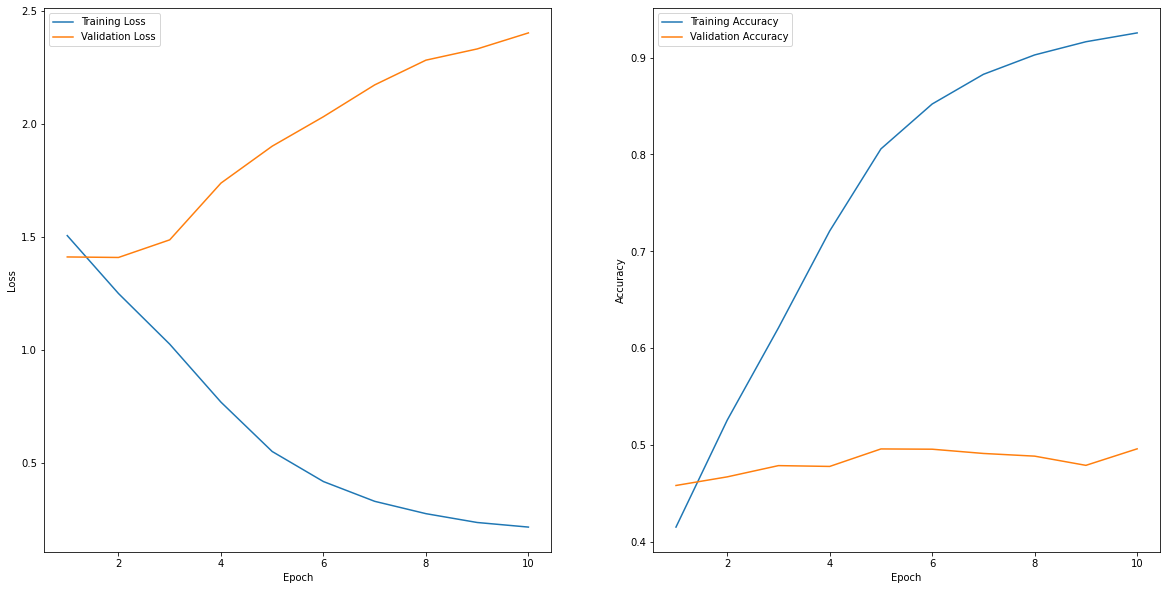

In [70]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot([i for i in range(1,epochs+1)], loss_train, label="Training Loss")
plt.plot([i for i in range(1,epochs+1)], loss_val_array, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot([i for i in range(1,epochs+1)], accuracy_train_array, label = "Training Accuracy")
plt.plot([i for i in range(1,epochs+1)], accuracy_val_array, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

In [71]:
con_mat = confusion_matrix(y_true, y_pred)

number_of_classes = con_mat.shape[0]

for i in range(number_of_classes):

    tp = con_mat[i, i]
    fn = np.sum(con_mat[i, :]) - tp
    fp = np.sum(con_mat[:, i]) - tp
    tn = np.sum(con_mat) - (tp + fn + fp)

    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0

    tpr = tp / (tp + fn) if tp + fn != 0 else 0
    fpr = fp / (fp + tn) if fp + tn != 0 else 0

    print(f"Class {i + 1} - True Positive Rate: {tpr:.2f}, False Positive Rate: {fpr:.2f}")
    print(f"Class {i + 1} - Precision: {precision:.2f}, Recall: {recall:.2f}")
    print()

Class 1 - True Positive Rate: 0.47, False Positive Rate: 0.14
Class 1 - Precision: 0.35, Recall: 0.47

Class 2 - True Positive Rate: 0.45, False Positive Rate: 0.00
Class 2 - Precision: 0.66, Recall: 0.45

Class 3 - True Positive Rate: 0.35, False Positive Rate: 0.08
Class 3 - Precision: 0.44, Recall: 0.35

Class 4 - True Positive Rate: 0.65, False Positive Rate: 0.04
Class 4 - Precision: 0.84, Recall: 0.65

Class 5 - True Positive Rate: 0.38, False Positive Rate: 0.13
Class 5 - Precision: 0.36, Recall: 0.38

Class 6 - True Positive Rate: 0.57, False Positive Rate: 0.04
Class 6 - Precision: 0.68, Recall: 0.57

Class 7 - True Positive Rate: 0.56, False Positive Rate: 0.16
Class 7 - Precision: 0.42, Recall: 0.56



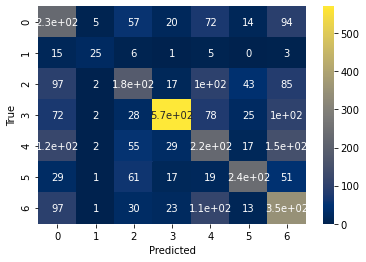

<Figure size 1440x720 with 0 Axes>

In [72]:
sns.heatmap(con_mat, annot = True, cmap = 'cividis', cbar = True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.figure(figsize=(20,10))
plt.show()

In [73]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Precision: 0.540202535811535
Recall: 0.5062691557536918
F1: 0.5156901734201564


In [74]:
import time

s = time.time()

torch.manual_seed(18)
np.random.seed(18)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelResnet0.parameters(), lr = 0.001, weight_decay = 0.001)

epochs = 10

bs = 16
loss_val_array , loss_train , accuracy_train_array , accuracy_val_array = [], [], [], []

for epoch in range(epochs):
    modelResnet0.train() 
    loss_sum_train = 0
    c = 0
    acc = 0
    for j in range(0, len(X_train), bs):
        
        c += 1
        X_traini = X_train[j:j+bs]
        X_traini = X_traini.to(device)
        Y_traini = Y_train[j:j+bs]
        Y_traini = Y_traini.to(device)
        y_pred = modelResnet0(X_traini) 
        loss = criterion(y_pred, Y_traini)
        loss_sum_train += loss.item()  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(y_pred, 1) 
        accuracy = (predicted == Y_traini).sum().item() / len(Y_traini)
        acc += accuracy

    accuracy_train_array.append(acc/c)

    loss_avg = loss_sum_train / c
    loss_train.append(loss_avg)

    print(f"Epoch No.{epoch + 1} -> Training loss: {loss_avg}")
    print(f"Epoch No.{epoch + 1} -> Training Accuracy: {acc/c}")

    modelResnet0.eval()  

    with torch.no_grad():
        loss_val_sum = 0
        C = 0
        acc = 0
        for k in range(0, len(X_val), bs):
            C += 1
            X_vali = X_val[k:k+bs]
            Y_vali = Y_val[k:k+bs]
            X_vali = X_vali.to(device)
            Y_vali = Y_vali.to(device)
            y_pred_val = modelResnet0(X_vali)  
            loss_val = criterion(y_pred_val, Y_vali)
            loss_val_sum += loss_val.item()  
            _, predicted_val = torch.max(y_pred_val, 1)  
            accuracy_val = (predicted_val == Y_vali).sum().item() / len(Y_vali)
            acc += accuracy_val

        accuracy_val_array.append(acc / C)
        loss_val_avg = loss_val_sum / C
        loss_val_array.append(loss_val_avg)

    print(f"Epoch No.{epoch + 1} - Validation loss: {loss_val_avg}")
    print(f"Epoch No.{epoch + 1} - Validation Accuracy: {acc/C}")


e = time.time()

seconds = e - s

print(f"Execution time: {seconds:.4f} seconds")

Epoch No.1 -> Training loss: 1.4345088266728647
Epoch No.1 -> Training Accuracy: 0.4574930362116992
Epoch No.1 - Validation loss: 1.5754776361253526
Epoch No.1 - Validation Accuracy: 0.37877777777777777
Epoch No.2 -> Training loss: 1.3226548759054009
Epoch No.2 -> Training Accuracy: 0.5007172701949861
Epoch No.2 - Validation loss: 1.3741936405499777
Epoch No.2 - Validation Accuracy: 0.46455555555555555
Epoch No.3 -> Training loss: 1.2769929182562656
Epoch No.3 -> Training Accuracy: 0.5170403899721449
Epoch No.3 - Validation loss: 1.3517772388458251
Epoch No.3 - Validation Accuracy: 0.4751666666666666
Epoch No.4 -> Training loss: 1.223361378127818
Epoch No.4 -> Training Accuracy: 0.5398119777158774
Epoch No.4 - Validation loss: 1.341810232533349
Epoch No.4 - Validation Accuracy: 0.48150000000000004
Epoch No.5 -> Training loss: 1.170680684830817
Epoch No.5 -> Training Accuracy: 0.5584122562674095
Epoch No.5 - Validation loss: 1.3076070862346225
Epoch No.5 - Validation Accuracy: 0.5020555

In [75]:
with torch.no_grad():
    modelResnet0.eval()
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_test = torch.tensor(Y_test, dtype=torch.long).to(device)
    loss_test_sum = 0
    acc_test = 0
    y_pred = []
    y_true = []

    for i in range(len(X_test)):
        X_test_i = X_test[i:i+1]
        Y_test_i = Y_test[i:i+1]

        y_pred_test = modelResnet0(X_test_i)
        y_pred.append(torch.argmax(y_pred_test, dim=1).item())
        y_true.append(Y_test_i.item())

        loss_test = criterion(y_pred_test, Y_test_i)
        loss_test_sum += loss_test

        _, predicted_test = torch.max(y_pred_test.data, 1)
        accuracy_test = (predicted_test == Y_test_i).sum().item() / len(Y_test_i)
        acc_test += accuracy_test

    accuracy_test_result = acc_test / len(X_test)
    print(f"Accuracy: {accuracy_test_result * 100:.2f}%")

    loss = loss_test_sum/(len(X_test))
y_true = np.array(y_true)
y_pred = np.array(y_pred)

<ipython-input-75-f9cc196ebf7f>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
<ipython-input-75-f9cc196ebf7f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test, dtype=torch.long).to(device)


Accuracy: 54.30%


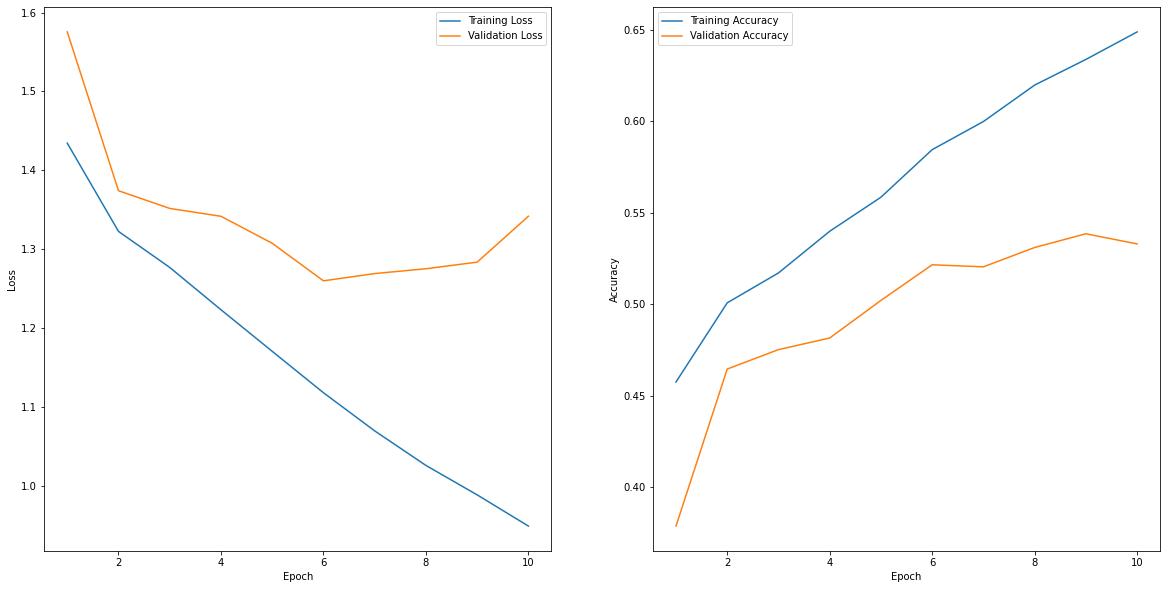

In [76]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot([i for i in range(1,epochs+1)], loss_train, label="Training Loss")
plt.plot([i for i in range(1,epochs+1)], loss_val_array, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot([i for i in range(1,epochs+1)], accuracy_train_array, label = "Training Accuracy")
plt.plot([i for i in range(1,epochs+1)], accuracy_val_array, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

In [77]:
con_mat = confusion_matrix(y_true, y_pred)

number_of_classes = con_mat.shape[0]

for i in range(number_of_classes):

    tp = con_mat[i, i]
    fn = np.sum(con_mat[i, :]) - tp
    fp = np.sum(con_mat[:, i]) - tp
    tn = np.sum(con_mat) - (tp + fn + fp)

    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0

    tpr = tp / (tp + fn) if tp + fn != 0 else 0
    fpr = fp / (fp + tn) if fp + tn != 0 else 0

    print(f"Class {i + 1} - True Positive Rate: {tpr:.2f}, False Positive Rate: {fpr:.2f}")
    print(f"Class {i + 1} - Precision: {precision:.2f}, Recall: {recall:.2f}")
    print()

Class 1 - True Positive Rate: 0.56, False Positive Rate: 0.13
Class 1 - Precision: 0.41, Recall: 0.56

Class 2 - True Positive Rate: 0.22, False Positive Rate: 0.00
Class 2 - Precision: 0.50, Recall: 0.22

Class 3 - True Positive Rate: 0.38, False Positive Rate: 0.10
Class 3 - Precision: 0.40, Recall: 0.38

Class 4 - True Positive Rate: 0.73, False Positive Rate: 0.06
Class 4 - Precision: 0.80, Recall: 0.73

Class 5 - True Positive Rate: 0.37, False Positive Rate: 0.11
Class 5 - Precision: 0.40, Recall: 0.37

Class 6 - True Positive Rate: 0.62, False Positive Rate: 0.03
Class 6 - Precision: 0.74, Recall: 0.62

Class 7 - True Positive Rate: 0.55, False Positive Rate: 0.12
Class 7 - Precision: 0.50, Recall: 0.55



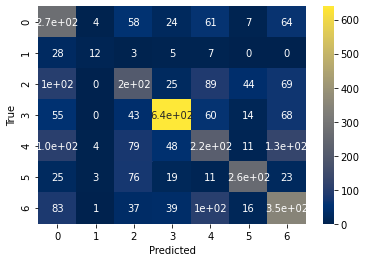

<Figure size 1440x720 with 0 Axes>

In [78]:
sns.heatmap(con_mat, annot = True, cmap = 'cividis', cbar = True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.figure(figsize=(20,10))
plt.show()

In [79]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Precision: 0.5566150543633681
Recall: 0.5430482028420173
F1: 0.5459982597362945


In [80]:
weights_val_resnet0op = modelResnet0.state_dict()
torch.save(weights_val_resnet0op, "modelResnet0op.pth")

In [83]:

class ResidualBlock(nn.Module):
    def _init_(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self)._init_()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet50(nn.Module):
    def _init_(self, num_classes=7):
        super(ResNet50, self)._init_()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(ResidualBlock, 64, 3)
        self.layer2 = self.make_layer(ResidualBlock, 128, 4, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 6, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def make_layer(self, block, channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != channels * 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channels * 4),
            )

        layers = []
        layers.append(block(self.in_channels, channels, stride, downsample))
        self.in_channels = channels * 4
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
modelResnet = ResNet50()

In [84]:
import time

s = time.time()

torch.manual_seed(18)
np.random.seed(18)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelResnet.parameters(), lr=0.0001)

epochs = 10

bs = 16
loss_val_array, loss_train, accuracy_train_array, accuracy_val_array = [], [], [], []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelResnet.to(device)

for epoch in range(epochs):
    modelResnet.train()
    loss_sum_train = 0
    correct_train = 0
    total_train = 0

    for j in range(0, len(X_train), bs):
        X_traini = X_train[j:j+bs].to(device)
        Y_traini = Y_train[j:j+bs].to(device)
        optimizer.zero_grad()
        y_pred = modelResnet(X_traini)
        loss = criterion(y_pred, Y_traini)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(y_pred, 1)
        correct_train += (predicted == Y_traini).sum().item()
        total_train += Y_traini.size(0)

        loss_sum_train += loss.item()

    accuracy_train = correct_train / total_train
    accuracy_train_array.append(accuracy_train)

    loss_avg = loss_sum_train / len(X_train)
    loss_train.append(loss_avg)

    print(f"Epoch No.{epoch + 1} -> Training loss: {loss_avg:.4f}")
    print(f"Epoch No.{epoch + 1} -> Training Accuracy: {accuracy_train:.4f}")

    modelResnet.eval()
    loss_val_sum = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for k in range(0, len(X_val), bs):
            X_vali = X_val[k:k+bs].to(device)
            Y_vali = Y_val[k:k+bs].to(device)
            y_pred_val = modelResnet(X_vali)
            loss_val = criterion(y_pred_val, Y_vali)
            loss_val_sum += loss_val.item()

            _, predicted_val = torch.max(y_pred_val, 1)
            correct_val += (predicted_val == Y_vali).sum().item()
            total_val += Y_vali.size(0)

    accuracy_val = correct_val / total_val
    accuracy_val_array.append(accuracy_val)

    loss_val_avg = loss_val_sum / len(X_val)
    loss_val_array.append(loss_val_avg)

    print(f"Epoch No.{epoch + 1} - Validation loss: {loss_val_avg:.4f}")
    print(f"Epoch No.{epoch + 1} - Validation Accuracy: {accuracy_val:.4f}")

e = time.time()

seconds = e - s

print(f"Execution time: {seconds:.4f} seconds")


Epoch No.1 -> Training loss: 0.0832
Epoch No.1 -> Training Accuracy: 0.4958
Epoch No.1 - Validation loss: 0.0709
Epoch No.1 - Validation Accuracy: 0.5745
Epoch No.2 -> Training loss: 0.0625
Epoch No.2 -> Training Accuracy: 0.6304
Epoch No.2 - Validation loss: 0.0730
Epoch No.2 - Validation Accuracy: 0.5751
Epoch No.3 -> Training loss: 0.0451
Epoch No.3 -> Training Accuracy: 0.7405
Epoch No.3 - Validation loss: 0.0794
Epoch No.3 - Validation Accuracy: 0.5848
Epoch No.4 -> Training loss: 0.0312
Epoch No.4 -> Training Accuracy: 0.8214
Epoch No.4 - Validation loss: 0.0886
Epoch No.4 - Validation Accuracy: 0.5963
Epoch No.5 -> Training loss: 0.0216
Epoch No.5 -> Training Accuracy: 0.8783
Epoch No.5 - Validation loss: 0.0978
Epoch No.5 - Validation Accuracy: 0.5862
Epoch No.6 -> Training loss: 0.0165
Epoch No.6 -> Training Accuracy: 0.9062
Epoch No.6 - Validation loss: 0.1039
Epoch No.6 - Validation Accuracy: 0.6046
Epoch No.7 -> Training loss: 0.0127
Epoch No.7 -> Training Accuracy: 0.9279


In [85]:
with torch.no_grad():
    modelResnet.eval()
    X_test = X_test.to(device)  
    Y_test = Y_test.to(device)  
    loss_test_sum = 0
    acc_test = 0
    y_pred = []
    y_true = []

    for i in range(len(X_test)):
        X_test_i = X_test[i:i+1]
        Y_test_i = Y_test[i:i+1]

        y_pred_test = modelResnet(X_test_i)
        y_pred.append(torch.argmax(y_pred_test, dim=1).item())
        y_true.append(Y_test_i.item())

        loss_test = criterion(y_pred_test, Y_test_i)
        loss_test_sum += loss_test.item()  

        _, predicted_test = torch.max(y_pred_test.data, 1)
        accuracy_test = (predicted_test == Y_test_i).sum().item() / len(Y_test_i)
        acc_test += accuracy_test

    accuracy_test_result = acc_test / len(X_test)
    print(f"Accuracy: {accuracy_test_result * 100:.2f}%")

    loss = loss_test_sum / len(X_test)  

y_true = np.array(y_true)
y_pred = np.array(y_pred)


Accuracy: 62.25%


In [86]:
weights_val_resnet = modelResnet.state_dict()
torch.save(weights_val_resnet, "modelResnet.pth")

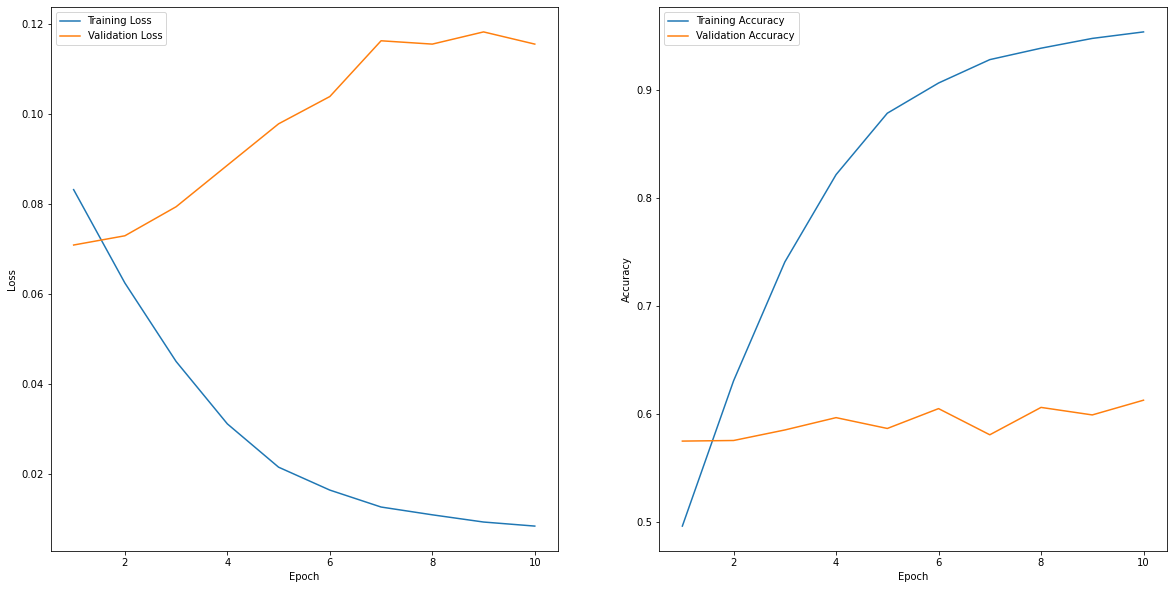

In [87]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot([i for i in range(1,epochs+1)], loss_train, label="Training Loss")
plt.plot([i for i in range(1,epochs+1)], loss_val_array, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot([i for i in range(1,epochs+1)], accuracy_train_array, label = "Training Accuracy")
plt.plot([i for i in range(1,epochs+1)], accuracy_val_array, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

In [88]:
con_mat = confusion_matrix(y_true, y_pred)

number_of_classes = con_mat.shape[0]

for i in range(number_of_classes):

    tp = con_mat[i, i]
    fn = np.sum(con_mat[i, :]) - tp
    fp = np.sum(con_mat[:, i]) - tp
    tn = np.sum(con_mat) - (tp + fn + fp)

    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0

    tpr = tp / (tp + fn) if tp + fn != 0 else 0
    fpr = fp / (fp + tn) if fp + tn != 0 else 0

    print(f"Class {i + 1} - True Positive Rate: {tpr:.2f}, False Positive Rate: {fpr:.2f}")
    print(f"Class {i + 1} - Precision: {precision:.2f}, Recall: {recall:.2f}")
    print()

Class 1 - True Positive Rate: 0.51, False Positive Rate: 0.08
Class 1 - Precision: 0.52, Recall: 0.51

Class 2 - True Positive Rate: 0.53, False Positive Rate: 0.00
Class 2 - Precision: 0.69, Recall: 0.53

Class 3 - True Positive Rate: 0.42, False Positive Rate: 0.07
Class 3 - Precision: 0.50, Recall: 0.42

Class 4 - True Positive Rate: 0.84, False Positive Rate: 0.06
Class 4 - Precision: 0.82, Recall: 0.84

Class 5 - True Positive Rate: 0.47, False Positive Rate: 0.10
Class 5 - Precision: 0.49, Recall: 0.47

Class 6 - True Positive Rate: 0.76, False Positive Rate: 0.04
Class 6 - Precision: 0.70, Recall: 0.76

Class 7 - True Positive Rate: 0.64, False Positive Rate: 0.10
Class 7 - Precision: 0.57, Recall: 0.64



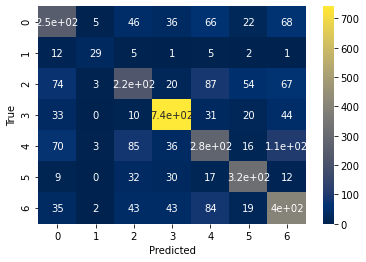

<Figure size 1440x720 with 0 Axes>

In [89]:
sns.heatmap(con_mat, annot = True, cmap = 'cividis', cbar = True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.figure(figsize=(20,10))
plt.show()

In [90]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Precision: 0.6173411703639246
Recall: 0.6224575090554472
F1: 0.6186796475942096


In [1]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

predictor = DefaultPredictor(cfg)

NameError: name 'get_cfg' is not defined